In [1]:
import pandas as pd
import numpy as np

from lightgbm import LGBMClassifier
from sklearn.preprocessing import OneHotEncoder
import sys
sys.path.append("/home/leon/projects/gaussian_process/")
from sklearn.model_selection import cross_val_score
from gecs100.gec import GEC
from gecs100.utils.gaussian_process_visualisation import visualise_1D_gaussian_process, visualise_2D_gaussian_process

gec = GEC()
#gec.load_gp_datas("./gp_datas.json")


In [2]:
path = "/home/leon/learning/gaussian-processes/bank/bank-full.csv"
data = pd.read_csv(path, sep=";")
one_hot_encode = ["job", "marital", "education", "contact", "poutcome", "month"]
binary = ["default", "housing", "loan", "y"]

enc = OneHotEncoder()
def yesNoBinary(column):
    return(pd.DataFrame([1 if value == "yes" else 0 for value in column], columns = [column.name]))
one_hot = pd.DataFrame(enc.fit_transform(data[one_hot_encode]).toarray(), columns=enc.get_feature_names_out(one_hot_encode))
data2 = pd.concat([one_hot] + [ yesNoBinary(data[col]) if col in binary else data[col] for col in data.columns ], 1).drop(one_hot_encode, 1)
X, y = data2.values[:,:-1], data2.values[:,-1]
np.random.seed(101)
ind = np.random.uniform(0, 1, X.shape[0]) <1.1
X = X[ind,:]
y = y[ind]

X_pos = X[y==1,:]
y_pos = y[y==1]

X_reweighted = np.concatenate([X] + [X_pos]*3, axis=0)
y_reweighted = np.concatenate([y] + [y_pos]*3)


print(X_reweighted.shape)

(61078, 48)


/tmp/ipykernel_53515/1665828294.py:10: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  data2 = pd.concat([one_hot] + [ yesNoBinary(data[col]) if col in binary else data[col] for col in data.columns ], 1).drop(one_hot_encode, 1)
/tmp/ipykernel_53515/1665828294.py:10: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data2 = pd.concat([one_hot] + [ yesNoBinary(data[col]) if col in binary else data[col] for col in data.columns ], 1).drop(one_hot_encode, 1)


In [3]:
gec.fit(X_reweighted, y_reweighted, 100)

  0%|          | 0/100 [00:00<?, ?it/s]

{'boosting': 'rf', 'num_leaves': 127, 'learning_rate': 0.027775233466662108, 'n_estimators': 200, 'bagging_fraction': 0.7500000000000002, 'bagging_freq': 1, 'max_bin': 250, 'max_depth': 400, 'lambda_l1': 0.5706563637125749, 'min_data_in_leaf': 29, 'feature_fraction': 0.47999999999999976}


  1%|          | 1/100 [00:09<15:47,  9.57s/it]

{'boosting': 'dart', 'num_leaves': 57, 'learning_rate': 0.04214489405599884, 'n_estimators': 1000, 'bagging_fraction': 0.9000000000000002, 'bagging_freq': 6, 'max_bin': 40, 'max_depth': 70, 'lambda_l1': 0.7294036972829212, 'min_data_in_leaf': 17, 'feature_fraction': 0.5899999999999997}


In [5]:
gec.rewards

{'gbdt': {'a': 1.1422282247154087, 'b': 1.0245110579440881},
 'dart': {'a': 1.0987906292913197, 'b': 1.1174855297958297},
 'rf': {'a': 1, 'b': 1.026573508148254}}

In [5]:
print({k:(np.mean(v["output"]), np.max(v["output"]), len(v["output"])) for k, v in gec.gp_datas.items()})

{'gbdt': (0.5900642817998459, 0.6215650898397342, 4), 'dart': (0.5819479941910743, 0.6792465518983364, 8), 'rf': (0.6514120859418917, 0.7030677394147675, 85)}


/home/leon/miniconda3/envs/dev/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]


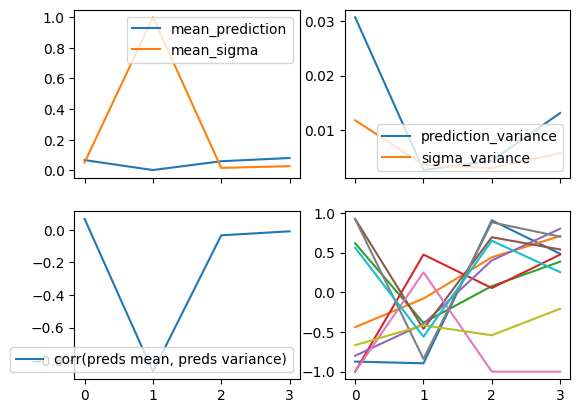

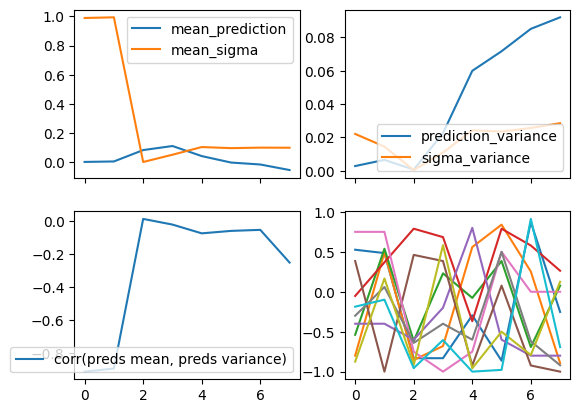

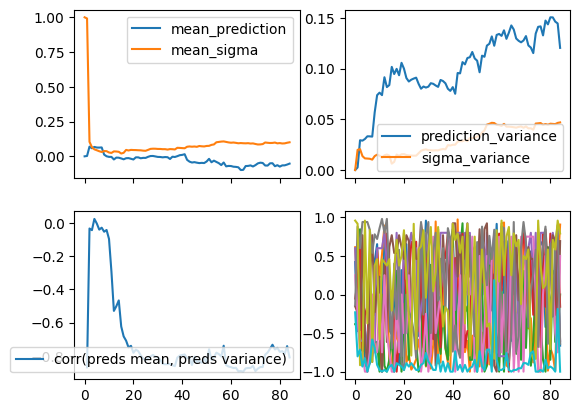

In [6]:
gec.save_figs("./test")

In [7]:
print(gec.best_params_)
knn_bayes = LGBMClassifier(**gec.best_params_)
score_bayes = np.mean(cross_val_score(knn_bayes, X_reweighted, y_reweighted, cv=5))
score_bayes

{'boosting': 'rf', 'num_leaves': 139, 'learning_rate': 0.022548315035021207, 'n_estimators': 30, 'bagging_fraction': 0.7500000000000002, 'bagging_freq': 6, 'max_bin': 500, 'max_depth': 400, 'lambda_l1': 0.2053373187150891, 'min_data_in_leaf': 26, 'feature_fraction': 0.13}
[LightGBM] [Warning] lambda_l1 is set=0.2053373187150891, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2053373187150891
[LightGBM] [Warning] bagging_fraction is set=0.7500000000000002, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7500000000000002
[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
[LightGBM] [Warning] feature_fraction is set=0.13, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.13
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: ba

0.727102167801781

In [8]:
print(gec.best_params_grid)
knn_bayes = LGBMClassifier(**gec.best_params_grid)
score_bayes = np.mean(cross_val_score(knn_bayes, X_reweighted, y_reweighted, cv=5))
score_bayes

{'boosting': 'dart', 'num_leaves': 25, 'learning_rate': 0.010023052380778996, 'n_estimators': 10, 'bagging_fraction': 0.8500000000000002, 'bagging_freq': 1, 'max_bin': 10, 'max_depth': -1, 'lambda_l1': 0.0, 'min_data_in_leaf': 2, 'feature_fraction': 0.1}
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] bagging_fraction is set=0.8500000000000002, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8500000000000002
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is s

0.6536232358413612

In [ ]:
gec.export_gp_datas("./gp_datas.json")

In [ ]:
np.mean(gec.predict(X))

0.0

In [ ]:
print(gec.best_params_)
knn_bayes = LGBMClassifier(**gec.best_params_)
score_bayes = np.mean(cross_val_score(knn_bayes, X, y, cv=5))
score_bayes

{'boosting': 'dart', 'num_leaves': 52, 'learning_rate': 0.31622776601683794, 'n_estimators': 10, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 2, 'max_bin': 70, 'max_depth': 100, 'lambda_l1': 0.5100900202791361, 'min_data_in_leaf': 13, 'feature_fraction': 0.13}
[LightGBM] [Warning] lambda_l1 is set=0.5100900202791361, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5100900202791361
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.13, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.13
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current val

0.8663419233186674

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
classifier = LGBMClassifier()
hyperparams = dict(gec.categorical_hyperparameters + gec.real_hyperparameters)
gs = RandomizedSearchCV(classifier, hyperparams, n_iter=100)
gs.fit(X_reweighted, y_reweighted)

[LightGBM] [Warning] lambda_l1 is set=0.016639666155303975, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.016639666155303975
[LightGBM] [Warning] bagging_fraction is set=0.9000000000000002, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9000000000000002
[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
[LightGBM] [Warning] feature_fraction is set=0.6599999999999997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6599999999999997
[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l1 is set=0.016639666155303975, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.016639666155303975
[LightGBM] [Warning] bagging_fraction is set=0.9000000000000002, subsample=1.0 will be igno

[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /__w/1/s/python-package/compile/src/boosting/rf.hpp, line 35 .

[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /__w/1/s/python-package/compile/src/boosting/rf.hpp, line 35 .

[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /__w/1/s/python-package/compile/src/boosting/rf.hpp, line 35 .

[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /__w/1/s/python-package/compile/src/boosting/rf.hpp, line 35 .

[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /__w/1/s/python-package/compile/src/boosting/rf.hpp, line 35 .



[LightGBM] [Warning] lambda_l1 is set=0.6371278508612026, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6371278508612026
[LightGBM] [Warning] bagging_fraction is set=0.6500000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6500000000000001
[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
[LightGBM] [Warning] feature_fraction is set=0.8399999999999996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8399999999999996
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l1 is set=0.6371278508612026, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6371278508612026
[LightGBM] [Warning] bagging_fraction is set=0.6500000000000001, subsample=1.0 will be ignored. Cur

/home/leon/miniconda3/envs/dev/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/home/leon/miniconda3/envs/dev/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/leon/miniconda3/envs/dev/lib/python3.10/site-packages/lightgbm/sklearn.py", line 967, in fit
    super().fit(X, _y, sample_weight=sample_weight, init_score=init_score, eval_set=valid_sets,
  File "/home/leon/miniconda3/envs/dev/lib/python3.10/site-packages/lightg

[LightGBM] [Warning] lambda_l1 is set=0.45490422386848667, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.45490422386848667
[LightGBM] [Warning] bagging_fraction is set=0.40000000000000013, subsample=1.0 will be ignored. Current value: bagging_fraction=0.40000000000000013
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.6899999999999997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6899999999999997
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


RandomizedSearchCV(estimator=LGBMClassifier(), n_iter=100,
                   param_distributions={'bagging_fraction': array([0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 ,
       0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
                                        'bagging_freq': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                        'boosting': ['gbdt', 'dart', 'rf'],
                                        'feature_fraction': array([0.1 , 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 ,
       0.21, 0....
       101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113,
       114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126,
       127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
       140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152,
       153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165,
       166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178,
       179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191,
       192, 193, 194, 195, 196, 197, 198, 199])})

In [ ]:
X_eval, y_eval = X_reweighted, y_reweighted
knn_bayes = LGBMClassifier(**gec.best_params_grid)
score_bayes = np.mean(cross_val_score(knn_bayes, X_eval, y_eval, cv=5))

knn_gs = LGBMClassifier(**gs.best_params_)
score_gs = np.mean(cross_val_score(knn_gs, X_eval, y_eval, cv=5))
knn_default = LGBMClassifier()
score_default = np.mean(cross_val_score(knn_default, X_eval, y_eval, cv=5))
print(f"bayesian: {score_bayes}, random search: {score_gs}, default: {score_default}")


[LightGBM] [Warning] lambda_l1 is set=0.2527276847641921, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2527276847641921
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.4099999999999998, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4099999999999998
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.2527276847641921, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2527276847641921
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM]

[(0.6227815905967627, 0.6782366689996021, 34),
 (0.6174991457005594, 0.6870278938527158, 33),
 (0.6358486354896773, 0.6707006951777958, 33)]

In [ ]:
list(gec.gp_datas.values())[0].keys()

dict_keys(['inputs', 'output', 'means', 'sigmas'])

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.utils.extmath import cartesian
from sklearn.gaussian_process.kernels import RBF, ConstantKernel

gaussian = GaussianProcessRegressor(kernel=gec.kernel)
#gaussian.fit(result['uniform'][0], result['uniform'][0].dot(np.array([1.0, 3.0]))/500)
gaussian.fit(gec.gp_datas['gbdt'][0], gec.gp_datas['gbdt'][1])

KeyError: 0

In [ ]:
visualise_2D_gaussian_process(gaussian, (np.logspace(0.00, 1, 50) -1)/9, np.arange(10, 200, 1), np.arange(0.5, 1, 0.1))

In [ ]:
print(gec.best_params_)
knn_bayes = LGBMClassifier(**gec.best_params_)
score_bayes = np.mean(cross_val_score(knn_bayes, X, y, cv=5))
score_bayes

In [ ]:
knn_bayes = LGBMClassifier(**{'boosting': 'gbdt', 'lambda_l1': 0.46, 'num_leaves': 12})
score_bayes = np.mean(cross_val_score(knn_bayes, X, y, cv=5))
score_bayes